# P.C data in kWh
https://www.kaggle.com/datasets/jeanmidev/smart-meters-in-london

In [1]:
import pandas as pd
import numpy as np 
import missingno as msno 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt 
import dask.dataframe as dd
import warnings

warnings.filterwarnings('ignore')
color_palette= sns.color_palette()


In [2]:
color_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
df0= pd.read_csv('halfhourly_dataset/block_0.csv')
df1= pd.read_csv('halfhourly_dataset/block_1.csv')
df2= pd.read_csv('halfhourly_dataset/block_2.csv')
df3= pd.read_csv('halfhourly_dataset/block_3.csv')
df4= pd.read_csv('halfhourly_dataset/block_4.csv')

In [4]:
df= pd.concat([df0
,df1
,df2
,df3
,df4])

# Understanding Data

In [5]:
df.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2012-10-12 00:30:00.0000000,0
1,MAC000002,2012-10-12 01:00:00.0000000,0
2,MAC000002,2012-10-12 01:30:00.0000000,0
3,MAC000002,2012-10-12 02:00:00.0000000,0
4,MAC000002,2012-10-12 02:30:00.0000000,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7079490 entries, 0 to 1473175
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   LCLid           object
 1   tstp            object
 2   energy(kWh/hh)  object
dtypes: object(3)
memory usage: 216.0+ MB


In [7]:
print(f'Shape: {df.shape}')

Shape: (7079490, 3)


# Data Cleaning

## Handling Missing Values

In [8]:
df[df['energy(kWh/hh)'] == 'Null']

,LCLid,tstp,energy(kWh/hh)
3238,MAC000002,2012-12-19 12:37:27.0000000,Null
42441,MAC000246,2012-12-18 15:13:37.0000000,Null
76341,MAC000450,2012-12-18 15:15:38.0000000,Null
94080,MAC001074,2012-12-18 15:18:11.0000000,Null
98616,MAC003223,2012-12-18 15:23:00.0000000,Null
...,...,...,...
1320867,MAC005066,2012-12-18 15:20:29.0000000,Null
1351403,MAC005112,2012-12-18 15:20:35.0000000,Null
1387035,MAC005320,2012-12-18 15:14:51.0000000,Null
1419661,MAC005489,2012-12-18 15:16:27.0000000,Null


In [9]:
df.replace({'Null': np.nan}, inplace= True)

<Axes: >

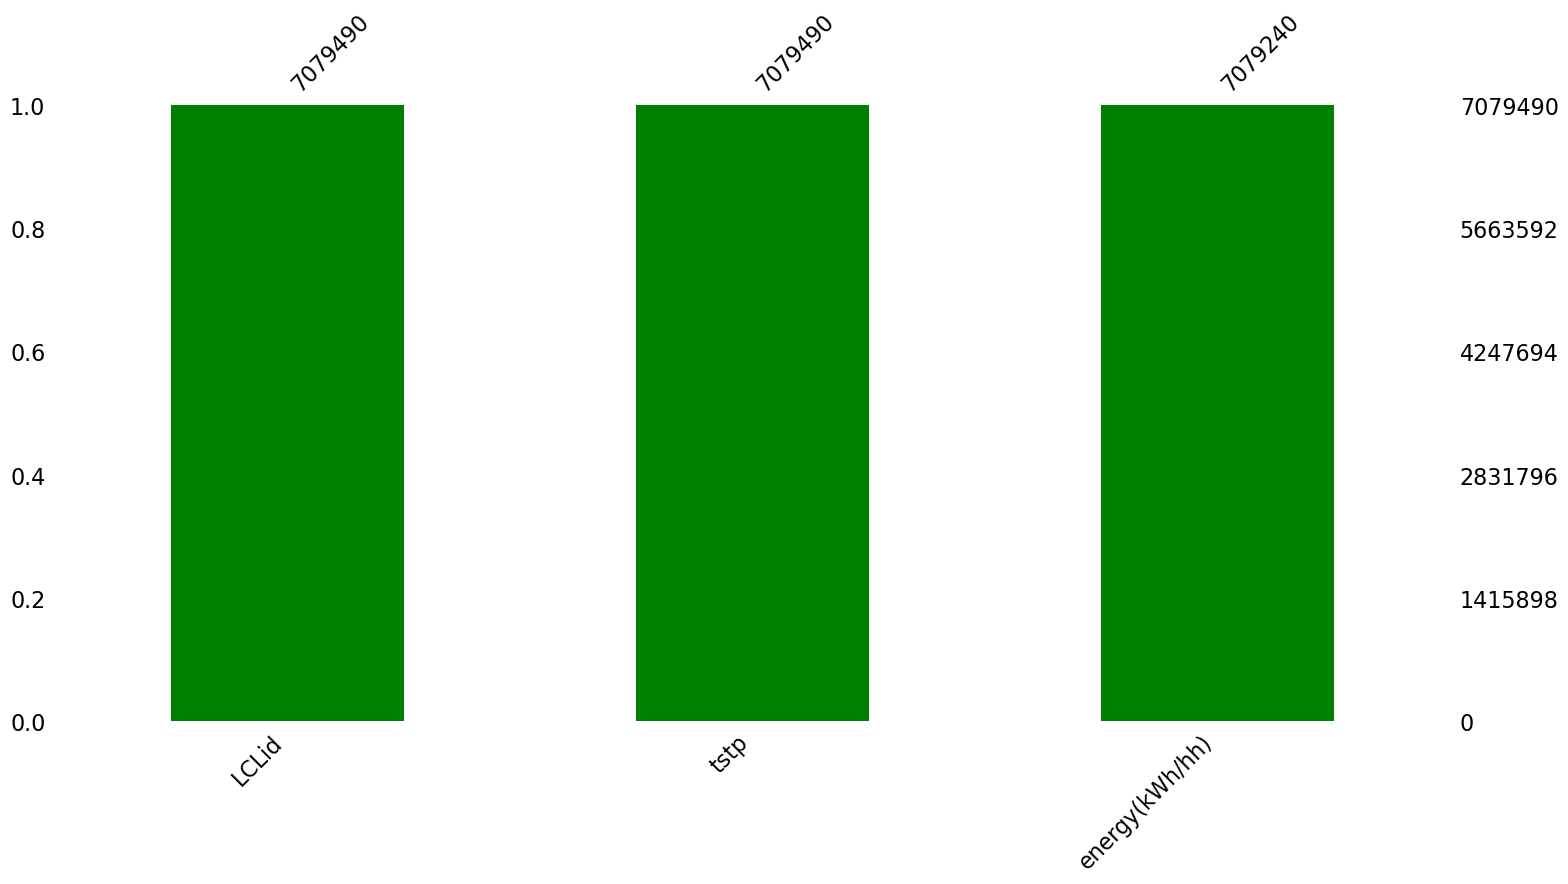

In [10]:
msno.bar(df, figsize=(18,8), color='green')

We can notice that `energy(KWh/hh)` has less than 1% of its values missing 

In [11]:
(df.isna().sum()/len(df))*100

LCLid             0.000000
tstp              0.000000
energy(kWh/hh)    0.003531
dtype: float64

# Feature Enegineering 

In [12]:
df.dropna(inplace=True)

In [13]:
df.reset_index(inplace=True)

In [14]:
df.drop('index', axis=1, inplace=True)

In [15]:
df['tstp']= pd.to_datetime(df['tstp'])

In [16]:
df['tstp']= df['tstp'].dt.floor('H')

In [17]:
df['energy(kWh/hh)']= df['energy(kWh/hh)'].astype('float64')

### `energy(kWh/hh)` Column

In [18]:
def energy_sum(grouped_df):
    
    grouped_df['energy(kWh/hh)']= grouped_df['energy(kWh/hh)'].sum()
    return grouped_df

In [19]:
df= df.groupby('tstp').apply(energy_sum)

In [20]:
df.reset_index(drop=True, inplace=True)

In [21]:
df['LCLid'].nunique()

250

In [22]:
df.drop_duplicates(inplace=True)

In [23]:
df.reset_index(drop=True, inplace=True)

###  `tstp` Column

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540468 entries, 0 to 3540467
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   tstp            datetime64[ns]
 2   energy(kWh/hh)  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 81.0+ MB


In [25]:
df['year']= df['tstp'].dt.year

In [26]:
df['month']= df['tstp'].dt.month_name()

In [27]:
df['week_day']= df['tstp'].dt.day_name()

In [28]:
def weekend(week_day):
    if (week_day== 'Saturday' or week_day == 'Sunday'):
        return 1
    else:
        return 0 

In [29]:
df['weekend']= df['week_day'].apply(weekend)

In [30]:
df['day_Hour']= df['tstp'].dt.hour

In [31]:
df['day-month']=  df['tstp'].dt.day.astype('str')+'-'+df['tstp'].dt.month.astype('str')

In [32]:
def holiday(day):
    if day== '1-1' or day== '29-3' or day== '1-4' or day=='6-5':
        return 1
    elif day== '27-5' or day== '26-8' or day== '25-12' or day== '26-12':
        return 1
    else:
        return 0

In [33]:
df['IsHoliday']= df['day-month'].apply(holiday)

In [34]:
df['quarter'] =df['tstp'].dt.quarter

In [35]:
def season(month):
    
    if month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    elif month in ['September', 'October', 'November']:
        return 'Autumn'
    else:
        return 'Winter'

In [36]:
df['season']= df['month'].apply(season)

In [37]:
df= df.iloc[:,[0,1,3,10,11,4,5,6,7,8,9,2]]

In [38]:
df.drop('day-month', axis=1, inplace= True)

df.to_csv('hourly_data.csv', index= False)

In [39]:
df.duplicated().sum()

0

# Outlier Analysis

In [40]:
df.rename(columns={
    'energy(kWh/hh)': 'energy_kWh'
},
          inplace=True
)

In [41]:
index_df= df.set_index('tstp')

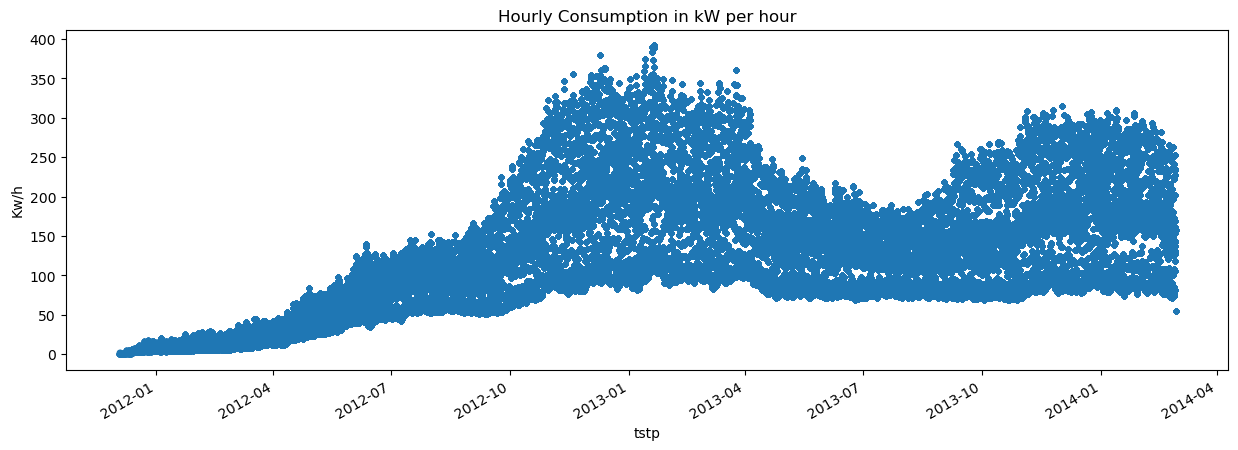

In [42]:
index_df['energy_kWh'].plot(
    style='.',
    figsize=(15,5),
    color= color_palette[0],
    title= 'Hourly Consumption in kW per hour',
    ylabel= 'Kw/h'
)
plt.show()

<Axes: ylabel='Frequency'>

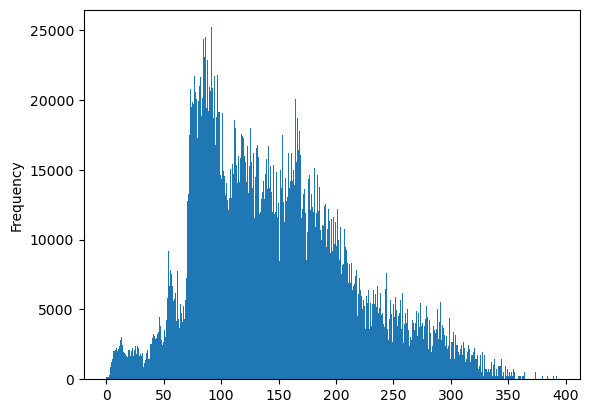

In [43]:
index_df['energy_kWh'].plot(
    kind= 'hist',
    bins=500
)

<Axes: ylabel='energy_kWh'>

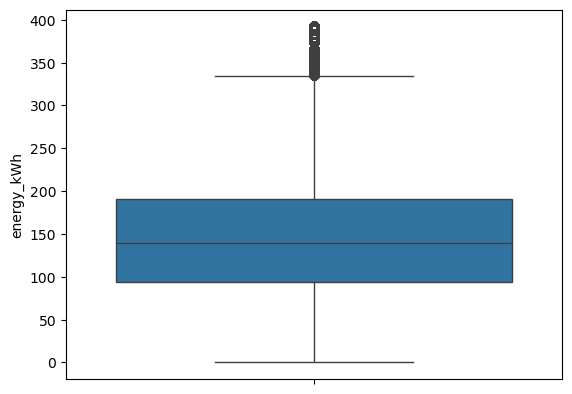

In [44]:
sns.boxplot(df['energy_kWh'])

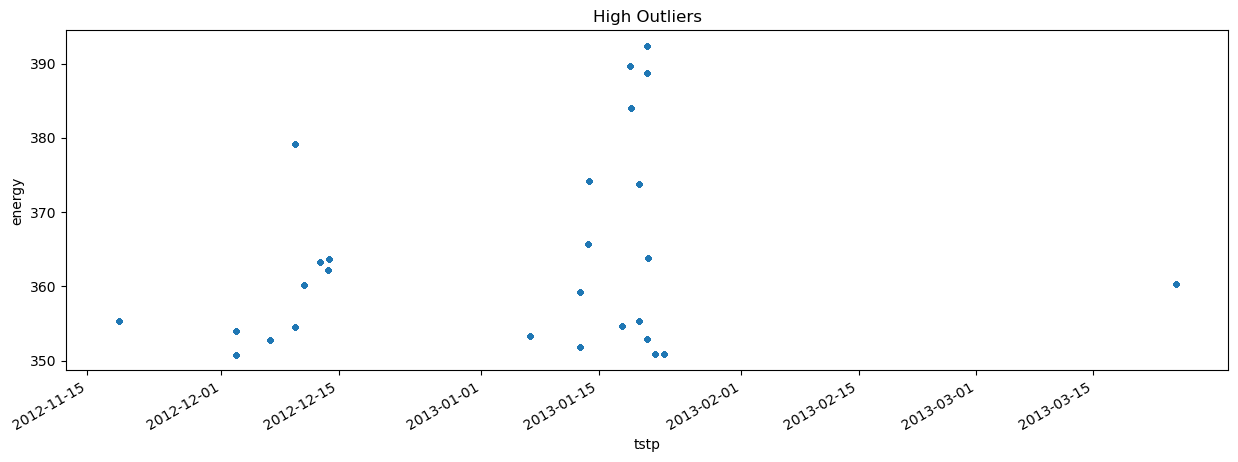

In [45]:
index_df[index_df['energy_kWh'] > 350]['energy_kWh'].plot(
    style='.',
    figsize= (15,5),
    ylabel= 'energy',
    title= 'High Outliers'
);

In [46]:
index_df= index_df[index_df['energy_kWh']<350]

In [47]:
del df

# Exploratory Data Analysis


## Mutlivaruate plots functions

In [64]:
def point(x,y,flag_hue=0, hue= None, palette_lst= None):
    
    if flag_hue==1:
        plt.figure(figsize=(11,6))
        sns.pointplot(
            data= index_df,
            x=x,
            y=y,
            hue= hue,
            palette= palette_lst
        )
        plt.tight_layout()
        plt.show()
        
    else:
        plt.figure(figsize=(20,15))
        sns.pointplot(
            data= index_df,
            x=x,
            y=y,
        )
        plt.tight_layout()
        plt.show()
        

In [49]:
def boxplot(x,y,flag_hue=0,hue= None, palette_lst=None):
    
    if flag_hue==1:
        plt.figure(figsize=(15,8))
        sns.boxplot(
            data= index_df,
            x=x,
            y=y,
            hue= hue,
            palette= palette_lst
        )
        plt.tight_layout()
        plt.show()
    else:
        
        plt.figure(figsize=(20,15))
        sns.boxplot(
            data= index_df,
            x=x,
            y=y,
        )
        plt.tight_layout()
        plt.show()
        
    

In [50]:
def barplot(x,y,flag_hue=0,hue= None, palette_lst= None):
    
    if flag_hue==1 and palette_lst!=None:
        plt.figure(figsize=(15,8))
        sns.barplot(
            data= index_df,
            x=x,
            y=y,
            hue= hue,
            palette=palette_lst
        )
        plt.tight_layout()
        plt.show()
    elif flag_hue==1 and palette_lst== None:
        plt.figure(figsize=(15,8))
        sns.barplot(
            data= index_df,
            x=x,
            y=y,
            hue= hue,
            palette=color_palette
        )
        plt.tight_layout()
        plt.show()
        
    if flag_hue==0:
        
        plt.figure(figsize=(20,15))
        sns.barplot(
            data= index_df,
            x=x,
            y=y,
        )
        plt.tight_layout()
        plt.title(f'{x} energy consumption')
        plt.show()
        
    

## Multivariate Analysis 

From the below graph we can conclude that:
- Sunday has the highest Energy Consumption then Saturday

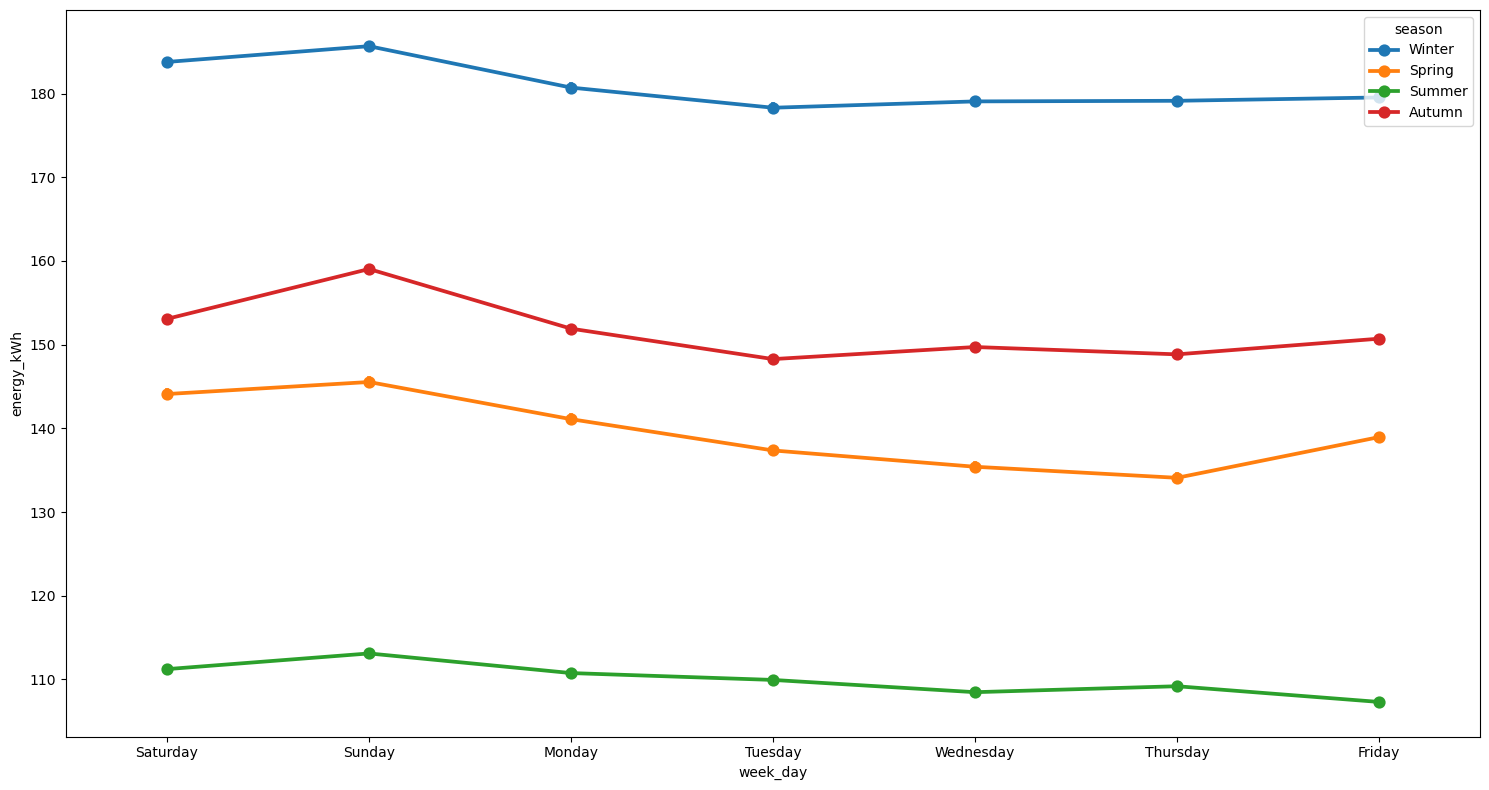

In [51]:
point(x= 'week_day', y='energy_kWh', flag_hue=1, hue='season')

From the below graph we can conclude that:
- Saturday and sunday in every seson has the highest energy consumption 
- In winter it has the highest energy consumption regeardless of the week day 
- In summer it has the lowes energy consumption regreadless of the week day 
- *Overall Conclusion*:  when the wheater gets colder the energy consumption increase 

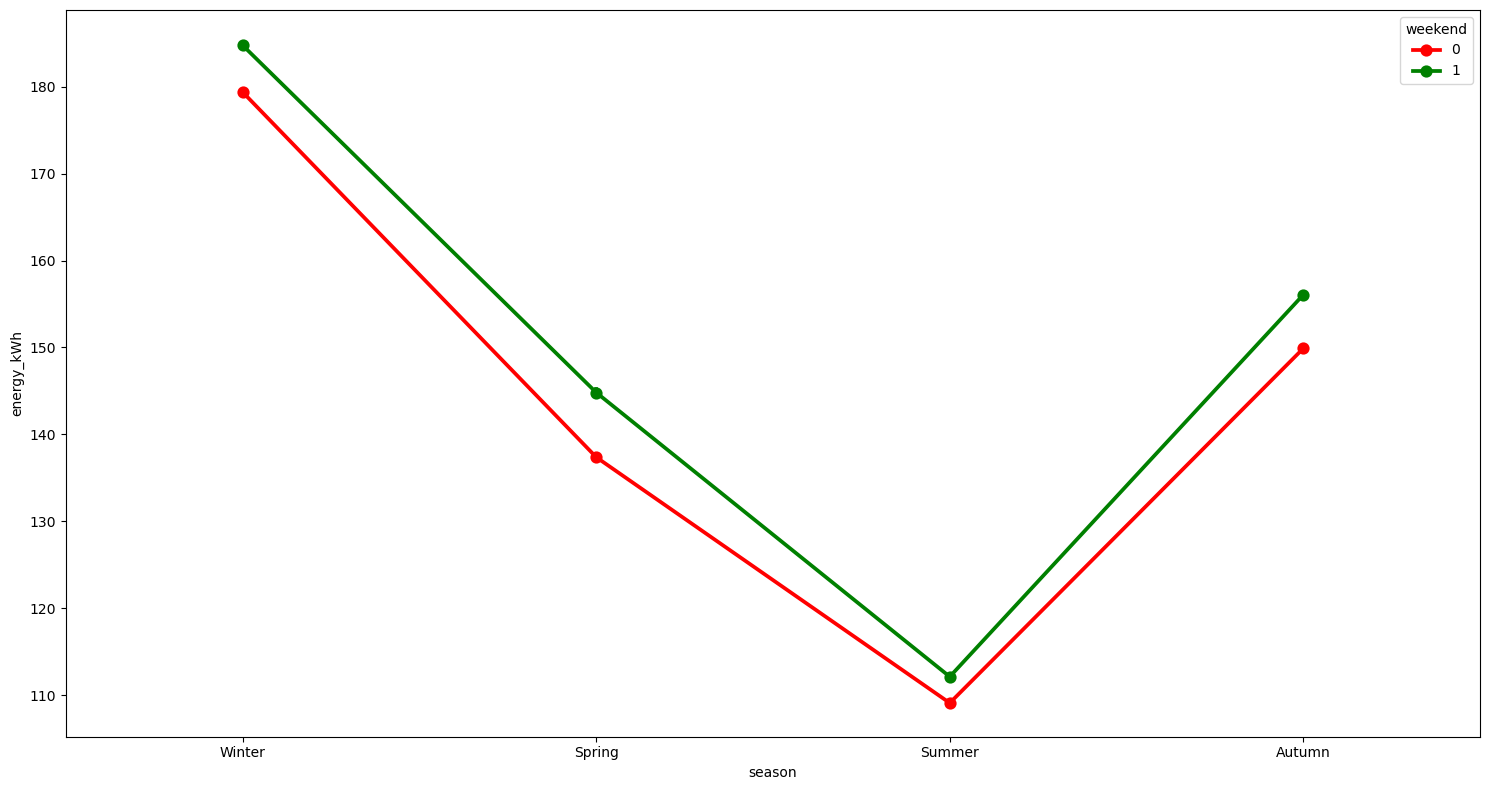

In [52]:
point(x='season', y= 'energy_kWh', flag_hue=1, hue= 'weekend', palette_lst=['r','g'])

From the below graph, we can conclude that:
- There no holidays in Autumn
- In most season the holiday day has the highest energy consumption 

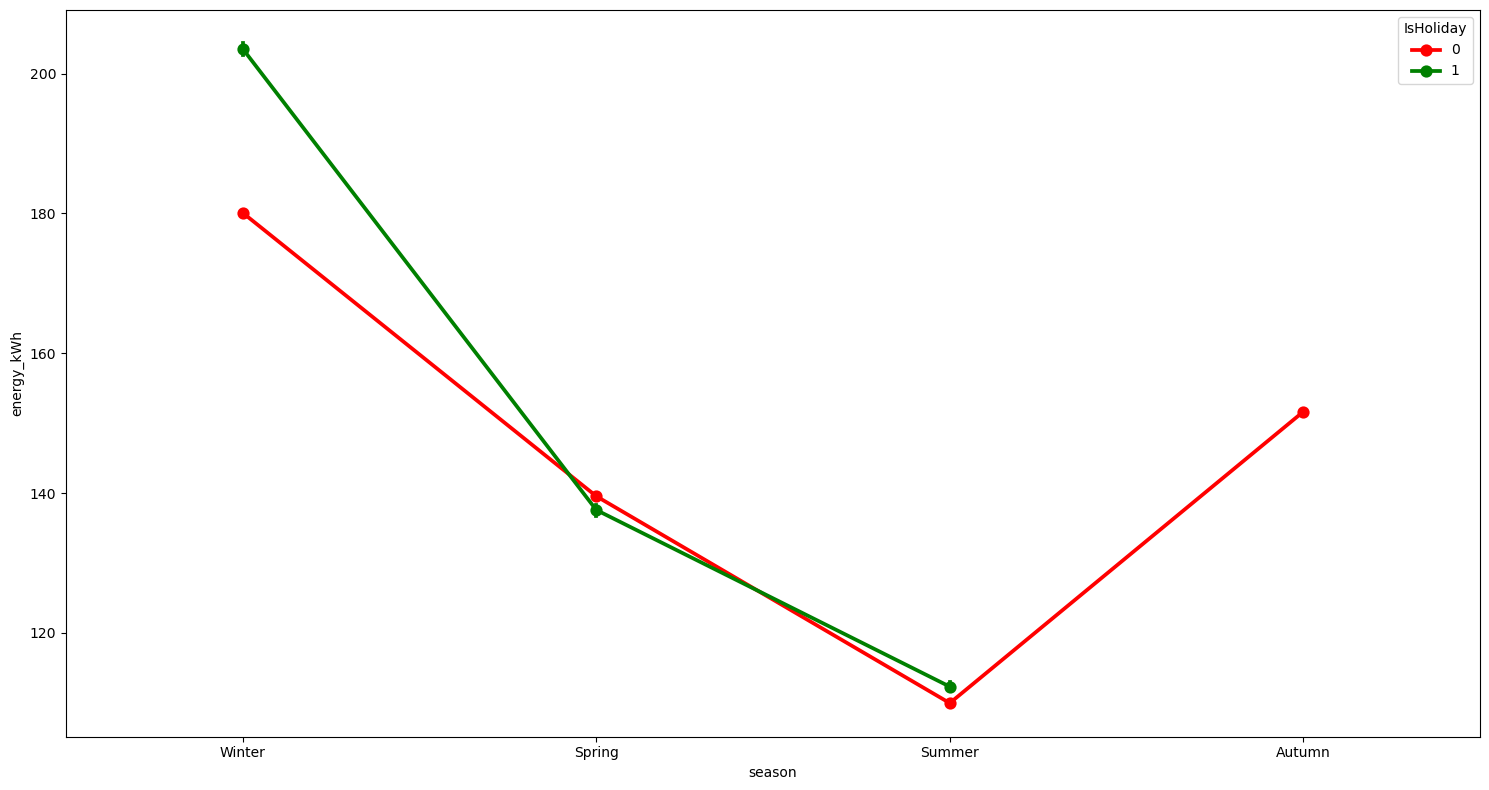

In [53]:
point(x='season', y= 'energy_kWh', flag_hue=1, hue= 'IsHoliday', palette_lst=['r','g'])

From the below graph, we can conclude that:


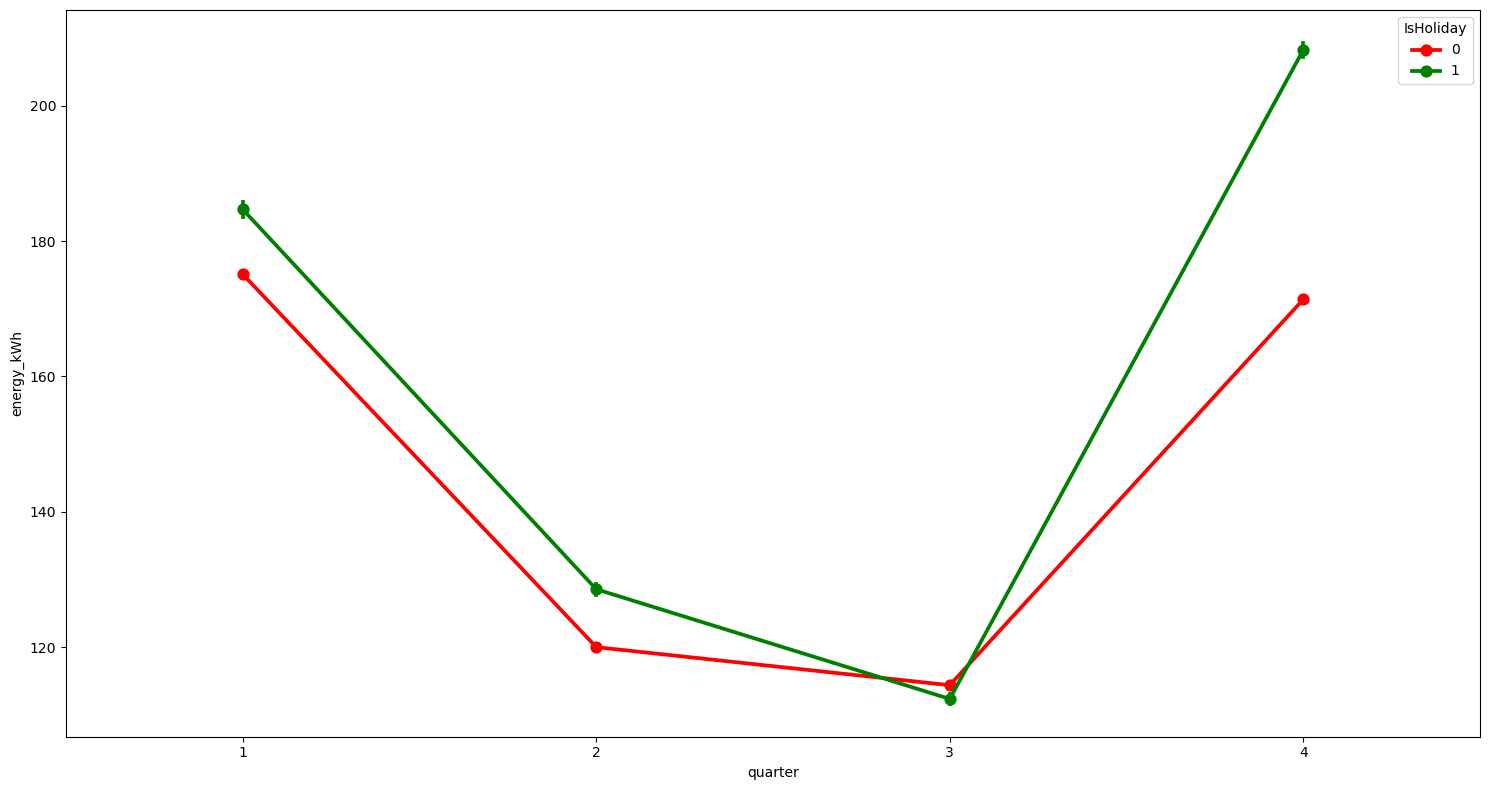

In [54]:
point(x='quarter', y= 'energy_kWh', flag_hue=1, hue='IsHoliday', palette_lst=['r','g'])

In [55]:
index_df.columns

Index(['LCLid', 'year', 'quarter', 'season', 'month', 'week_day', 'weekend',
       'day_Hour', 'IsHoliday', 'energy_kWh'],
      dtype='object')

From the below graph, we can conclude that:
- In the evening the energy consumption is the highest 
- In midnight the energy consumption is the lowest 

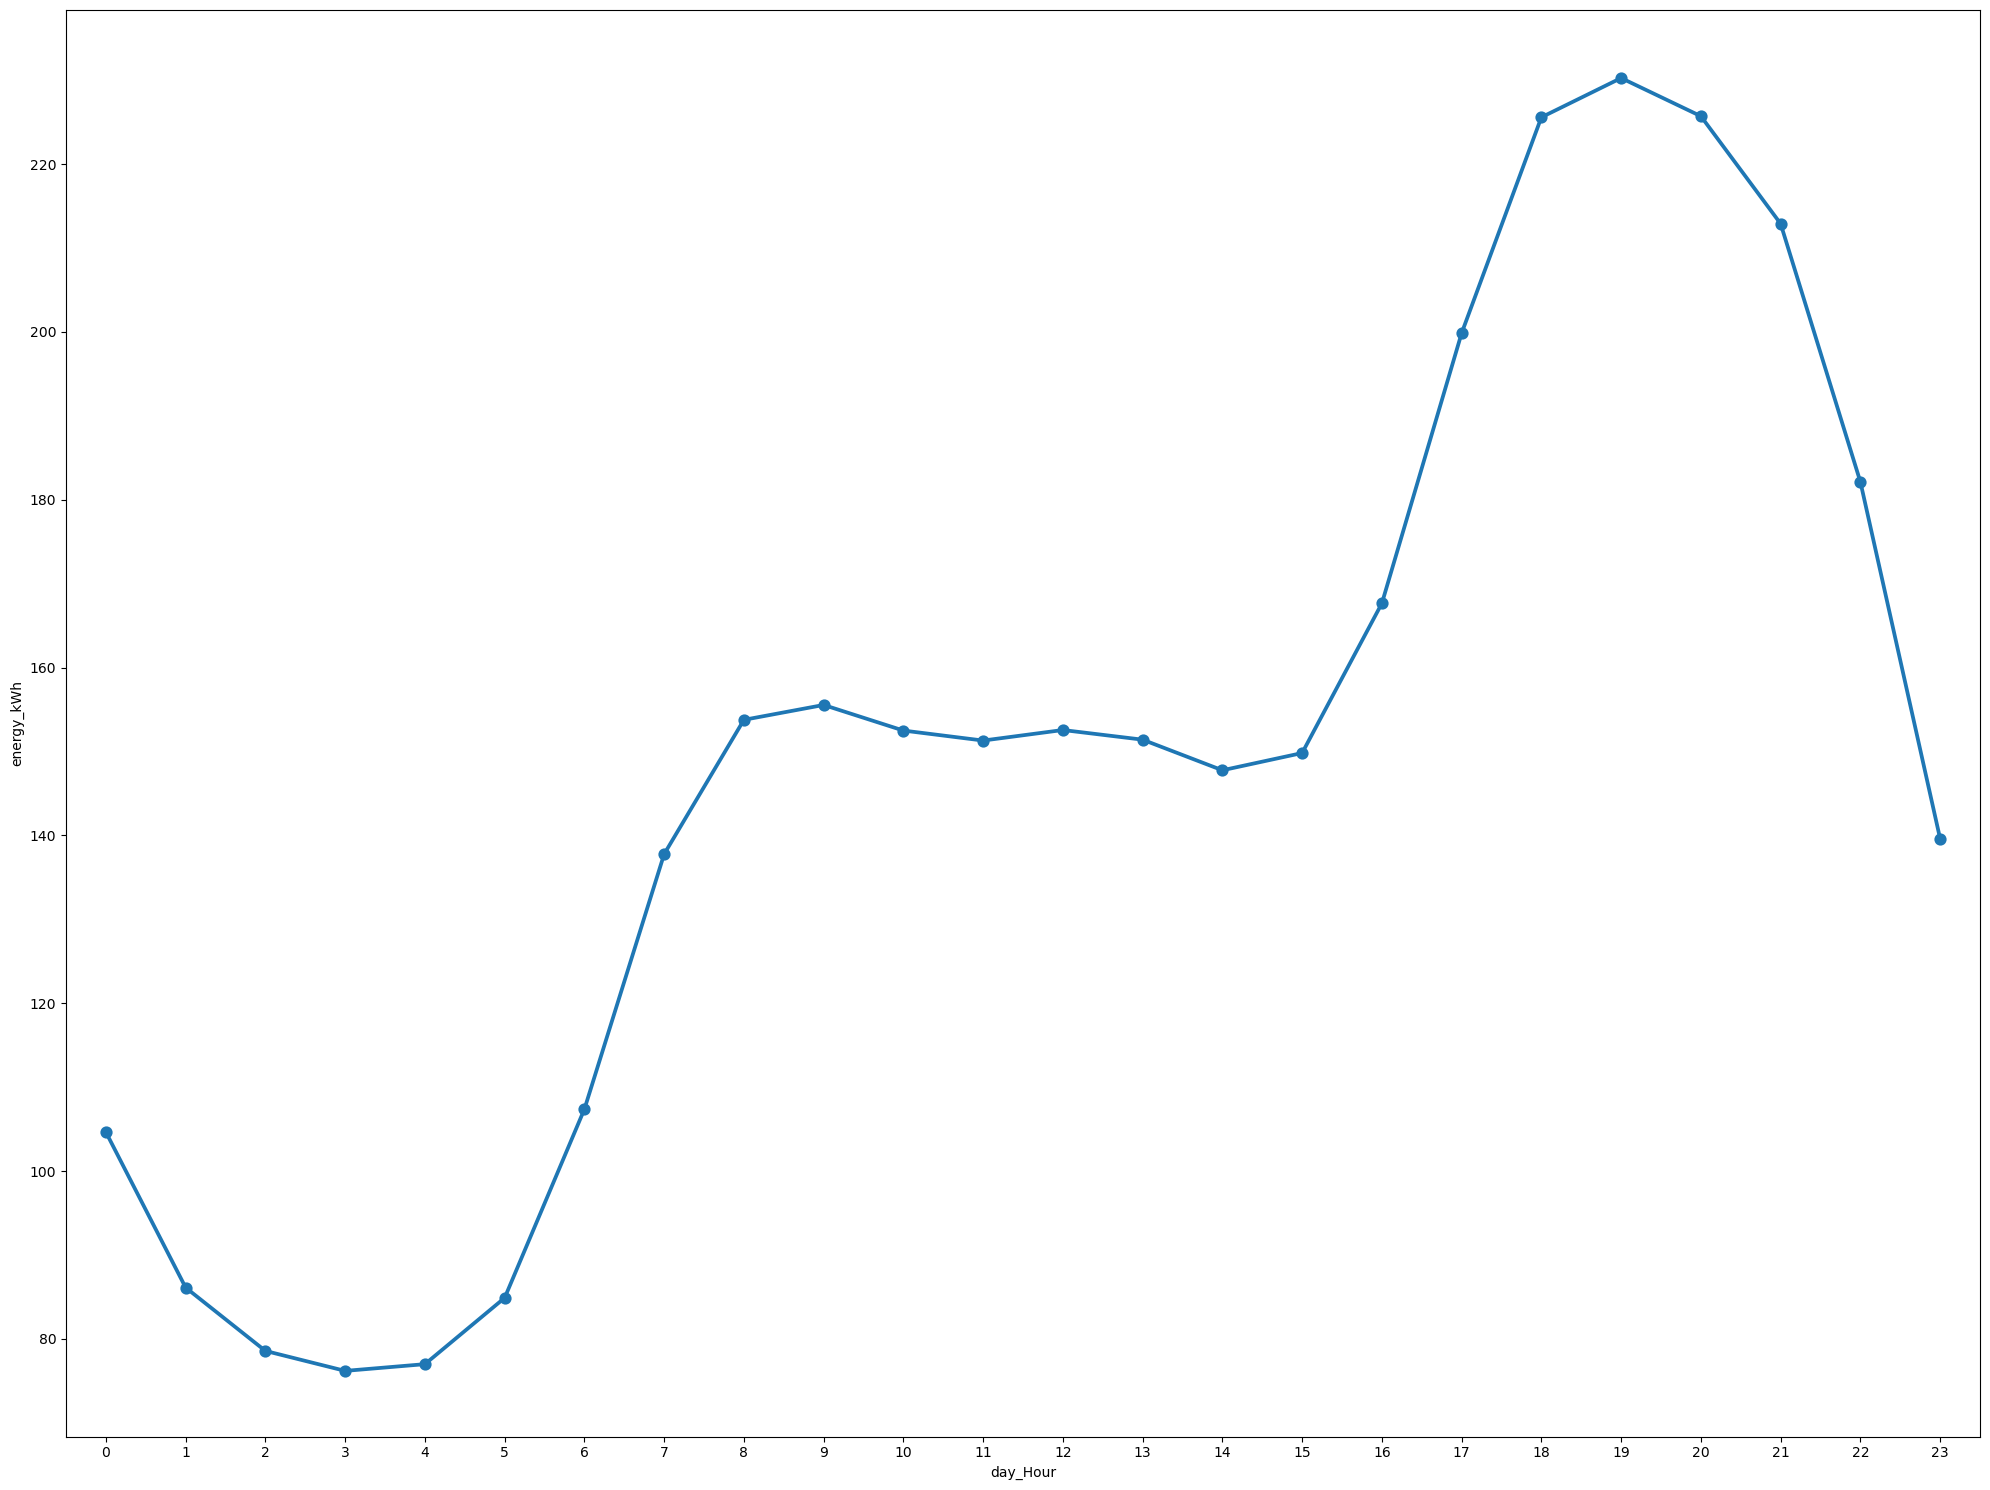

In [65]:
point('day_Hour', 'energy_kWh', flag_hue=0)

From the below graph, we can conclude that:
- In any month, weekends has the highest energy consumption 
- Dec, Mar, and Nov has the highest energy consumption whether this its a week end or not

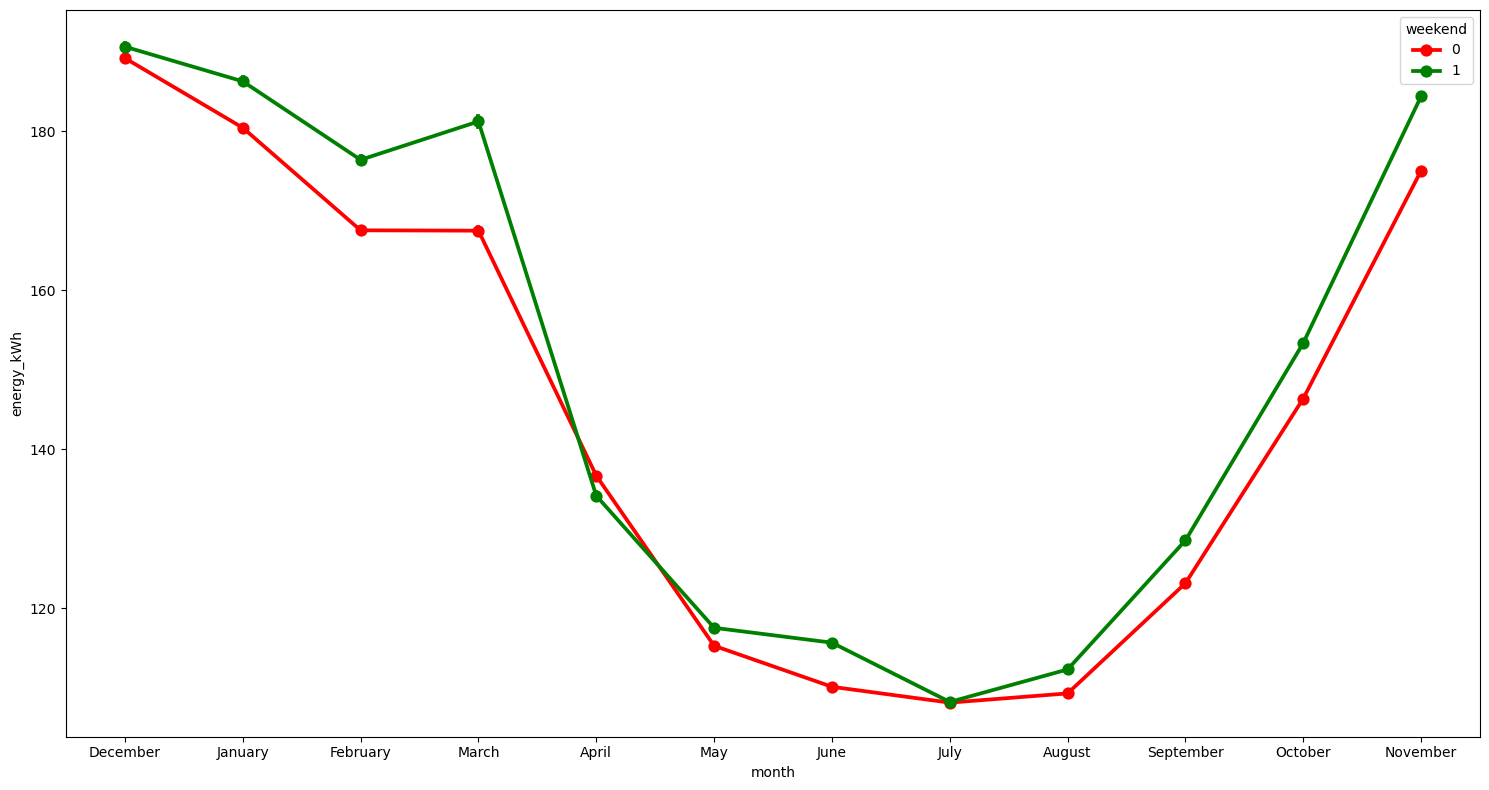

In [57]:
point(x='month', y='energy_kWh', flag_hue=1, hue='weekend', palette_lst=['r','g'])

In [58]:
index_df

,LCLid,year,quarter,season,month,week_day,weekend,day_Hour,IsHoliday,energy_kWh
tstp,,,,,,,,,,
2011-12-03 09:00:00,MAC000246,2011,4,Winter,December,Saturday,1,9,0,0.303
2011-12-03 10:00:00,MAC000246,2011,4,Winter,December,Saturday,1,10,0,1.947
2011-12-03 11:00:00,MAC000246,2011,4,Winter,December,Saturday,1,11,0,0.732
2011-12-03 12:00:00,MAC000246,2011,4,Winter,December,Saturday,1,12,0,1.595
2011-12-03 13:00:00,MAC000246,2011,4,Winter,December,Saturday,1,13,0,0.210
...,...,...,...,...,...,...,...,...,...,...
2014-02-28 00:00:00,MAC005066,2014,1,Winter,February,Friday,0,0,0,55.290
2014-02-28 00:00:00,MAC005112,2014,1,Winter,February,Friday,0,0,0,55.290
2014-02-28 00:00:00,MAC005320,2014,1,Winter,February,Friday,0,0,0,55.290


In [59]:
index_df.to_csv('indexed hourly energy consumption.csv')